### Challenge

I'm attaching two point cloud file links from dropbox below. The test is to develop an algorithm by any means (matlab, python, etc) that will automatically detect how many bumps are present in the point cloud.

Visually, here is what the sample point cloud looks like:



The bumps_16 file is a test-case where you have a known number of bumps (16 bumps) and can test your algorithm for accuracy. Once you have the algorithm working, test it against the second file (bumps.txt) and send the solution along with the algorithm/code you used to solve it.

The file has one point per line and is comma-delimited (format: X,Y,Z)!

https://www.dropbox.com/s/0xbq3pmopc0xj0w/bumps_16.txt?dl=0

https://www.dropbox.com/s/ng87d4eiqapbdvl/bumps.txt?dl=0

### Exploratory Data Analysis

Here we will load the data, explore the distributions, visualize the data, and prepare it for the model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Read "bumps_16.txt" as a csv and create a dataframe, df.  

In [2]:
df = pd.read_csv('bumps_16.txt', header = None)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254976 entries, 0 to 254975
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       254976 non-null  float64
 1   1       254976 non-null  float64
 2   2       254976 non-null  float64
dtypes: float64(3)
memory usage: 5.8 MB


Quarter million datapoints.

No null values, all values are floats

In [4]:
df.describe()

,0,1,2
count,254976.000000,254976.000000,254976.000000
mean,248.781432,248.903404,0.062928
std,144.287438,144.456639,0.696592
min,-38.963945,-36.604946,0.000000
25%,123.000000,123.000000,0.000000
50%,248.000000,249.500000,0.000000
75%,374.000000,374.000000,0.000000
max,499.000000,499.000000,17.028931


The first 2 dimensions have similar distributions, we will rename field 0 as x and field 1 as y.

There are no negatives in the 3rd dimension, majority of points have a 0 in the third dimension. We will rename field 3 as z.

In [5]:
df.columns = ['x', 'y', 'z']
df.head(3)

,x,y,z
0,63.395054,-16.268865,1.357733e-13
1,63.395054,-12.201649,1.846513e-03
2,63.395054,-8.134432,5.176077e-02


Let's plot the distributions.

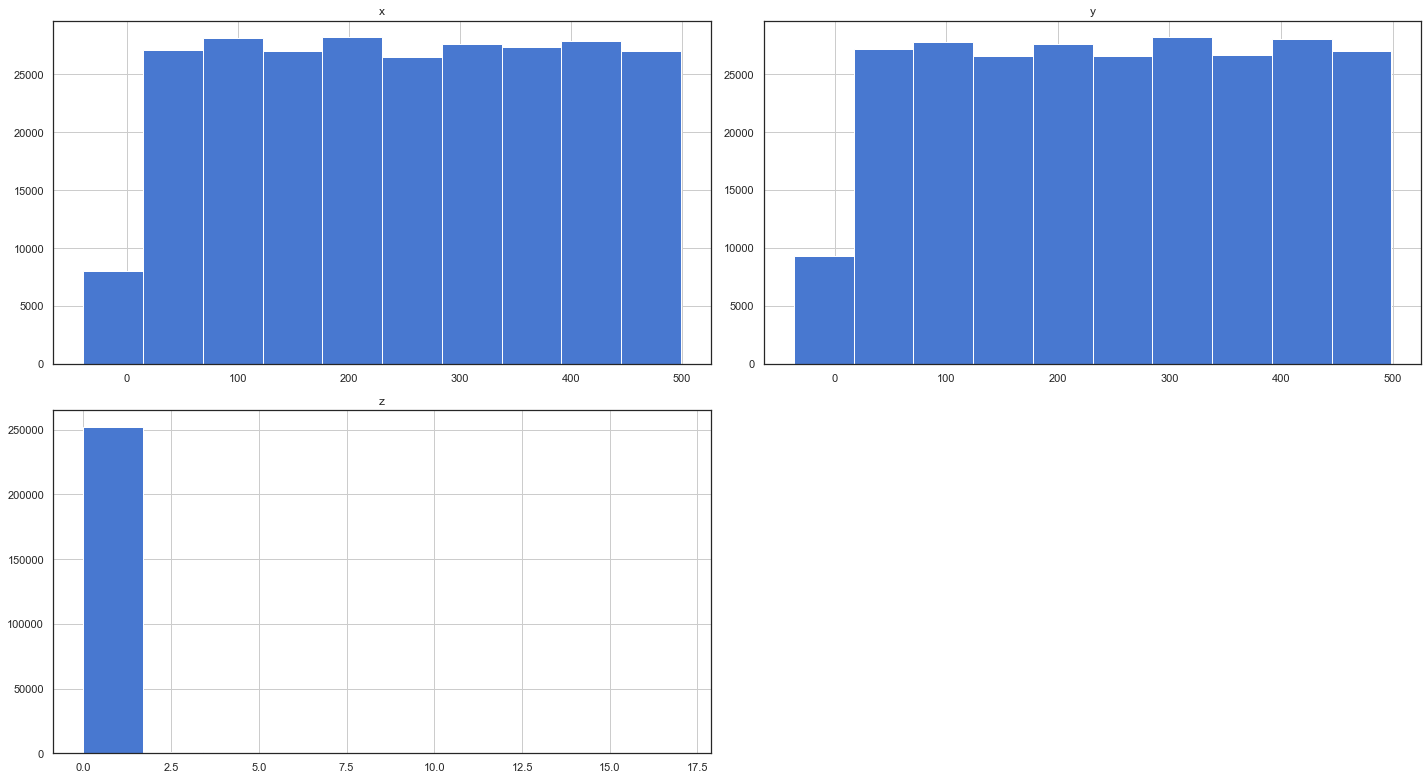

In [6]:
sns.set(style='white', palette='muted', color_codes=True)

df.hist(figsize = (20,11))
plt.tight_layout()

How about when we remove all points with height 0?

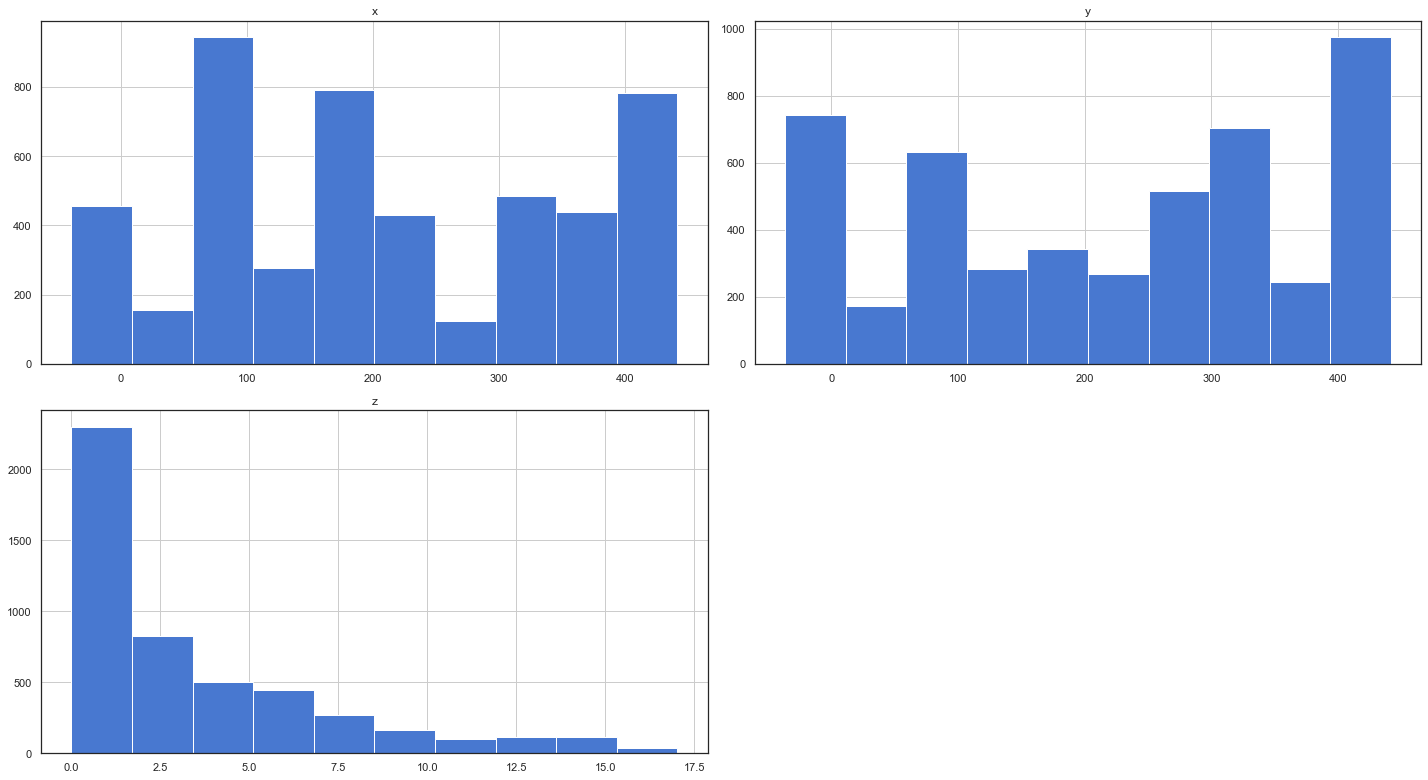

In [7]:
df[df['z'] != 0].hist(figsize = (20,11))
plt.tight_layout()

Lets look at the heights in z more closely.

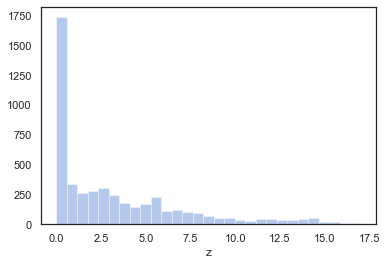

In [8]:
sns.distplot(df['z'][df['z'] != 0], kde = False, color="b")

How tall is the tallest bump?

In [9]:
df['z'].max()

17.028931254907743

We can visualize the bumps with a heatmap.

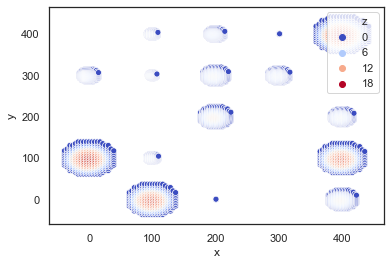

In [10]:
# Create a dataframe with no datapoints at height 0
df_1 = df[df['z'] != 0]

# Plot those datapoints with height as the color.
sns.scatterplot(x=df_1['x'], y=df_1['y'], hue=df_1['z'], palette='coolwarm')

How many datapoints are in a bump?

In [11]:
df_1.shape[0]

4880

### Createing a model

Here we will implement a clustering algorithm and count the number of clusters it find as the number of bumps.

This is the Density-Based Spacial Clustering Applications with Noise model, https://en.wikipedia.org/wiki/DBSCAN.  

The DBSCAN model operates by selecting a random point in the dataset, then counts the number of points which are within a distance set by the epsilon value (eps) hyperparameter.  Then, if that count is higher than the min_samples hyperparameter, the model creates a cluster and continues adding any points to that cluster that are within distance episolon of another point in the cluster.  Once there are no more points to add to the cluster, the model picks a random new point and begins the process anew.  Any points that are not within epsilon distance of a number of other points greater than min_samples will be labeled as noise with a -1 and not addeed to any cluster. 

This model does not take advantage of any data about the height of the bumps, and will count bumps of any shape (snaking hills, long walls, donuts, bumps that have bumps on them will be counted as 1).  It will also find dips below height 0 (holes and valleys). 

Please note that this function only works on datasets where the majority of datapoints are part of a flat 2D plane at height 0 and all bumps are spaced at least 6 units from the nearest bump.  

In [12]:
from sklearn.cluster import DBSCAN

# Define Density Based Spacial Clustering Applications w/ Noise clustering model.
dbscan_cluster = DBSCAN(eps=6, min_samples=2)

# Fit model
clusters = dbscan_cluster.fit_predict(df_1[['x', 'y']])

How many unique clusters did it find and how big are they?

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

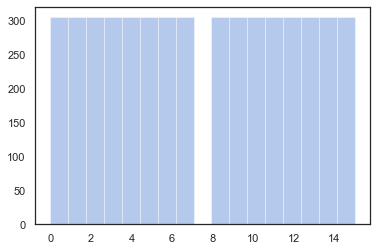

In [13]:
sns.distplot(clusters, kde = False, color="b")
np.unique(clusters)

Notice there were no clusters labeled -1, that means no points were identified as noise.  This indicates that there are no bumps on the surface too small for our hyperparameters to detect.  We should keep im mind that there is still the possibility bumps that have boundaries very close are being counted as one.  

How many clusters in total?

In [14]:
len(np.unique(clusters))

16

#### Conclusion

I chose this algorithm because it is a fast and simple way to find raised areas from a 2d array.  It does not require the values be quantized to a grid, it does not require the bumps to be round or smooth, and it does not spend resources iterating through the entire dataset mutiple times.  Also, it only require common python libraries: numpy, pandas, and sklearn.

I manually discovered the hyperparametes eps = 6 and min_samples = 2 by using knowledge of the use case, dataset, and a few minutes of trial and error.  However, for a better tuned model we could use a grid search to find the best hyperparameters.  However, in this case with only one training dataset which contains only 16 instances, I do not believe a grid search would be especially effective.

One of the major drawbacks to my approach is the step removing all datapoints with height 0.  For point clouds with continuous surfaces and no flat ground state this approach will not work.  The bumps must be spaced apart with flat areas between.  

The major advantage of my approach is the model will detect bumps of any shape (like donuts).


Other approaches I considered include:

Quantize all datapoints to a grid, then write an algorithm that found all local maxima in the z direction (height) along all slices in the x direction.  Then repeated that for all slices in the y direction.  Points that were a local maxima in bose cases would also be a 3D local maximum.  I believe the findpeaks function in matlab would be effective for this approach.  I am concerned that it would be a slow process to iterate through large point clouds.

Finding or writing a 3D array gradient descent algorithm and have it start at random points until it stops finding new local extrema, then count the number of extrema. I know the math behind gradient descent for a function that describes a 3D surface, but I was unsure how to implement that into a point cloud with no continuous function describing the surface.  I was also unsure of the best method to deal with cases where it finds the boundary edge instead of a local extrema.  

Use some sort of edge detecting library to find the edges of the "targets" created in the 2d heatmap with height as color.  This idea ultimately lead me to remembering the DBSCAN clustering algorithm that I had used in the past and so I shifted to that appraoch instead.  